# A SimCLR implementation for self-supervised learning from unlabeled data





##Objective:

In this assignment you have two tasks:
1. learn representations from an unlabeled dataset in an unsupervised/self-supervised way.
2. show how these learned representations can help improve results of
finetuning on a labeled dataset

##Steps:
1. Take the 'Example subset' dataset from https://github.com/zhuxlab/SSL4EO-S12
2. train a model using any self-supervised learning approach on above dataset. Some are mentioned in the above github (like contrastive
learning), but you can choose any other approach as well.
3. transfer this learning to a supervised learning task on any other
remote sensing dataset. You are free to make this choice but please keep
it a small dataset.
4. compare the results of step 3 with a model directly trained on the
dataset selected in step 3 without the pretraining of step 2

##Expected Output:
1. your notebooks/python files
2. your results and their interpretrations
3. We will discuss your results and reasons for the choices you made in this assignment over a call. You are free to make assumptions if anything
is not clear, but please clearly state that.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Model chosen: simCLR:

SimCLR is based out of the following simplified modules:
- A stochastic data augmentation module.
- A neural network base encoder $f(.)$.
- A neural network projection head $g(.)$
- A contrastive loss function.

We perform this learning task on the SSL4EO-S12 dataset. For the ease of implementation, we just work with their RGB data channel.

# Imports
The following imports will be used in the kernel.

In [7]:
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import (
    Dataset,
    DataLoader,
)

from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    ColorJitter,
    RandomGrayscale,
    RandomApply,
    Compose,
    GaussianBlur,
    ToTensor,
)
import torchvision.models as models

import os
import glob
import time
from skimage import io
import matplotlib.pyplot as plt

In [8]:
print(f'Torch-Version {torch.__version__}')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {DEVICE}')

Torch-Version 2.1.0+cu121
DEVICE: cuda


# Stochastic Augmentation Module

The authors suggest that a strong data augmentation is useful for unsupervised learning.
The following augmentation are suggested by the authors:
- Random Crop with Resize
- Random Horizontal Flip with 50% probability
- Random Color Distortion
    - Random Color Jitter with 80% probability
    - Random Color Drop with 20% probability
- Random Gaussian Blur with 50% probability


I do not play around much with the color distortions as I feel that color is an important distinguishing attribute of remote sensing data. Changing Green to blue can create confusion between green fields and blue water bodies. From aeriel imageris, since geometric information is not as important as color information.


In [9]:
def get_complete_transform(output_shape, kernel_size, s=1.0):
    """
    The color distortion transform.

    Args:
        s: Strength parameter.

    Returns:
        A color distortion transform.
    """
    rnd_crop = RandomResizedCrop(output_shape)
    rnd_flip = RandomHorizontalFlip(p=0.5)

    color_jitter = ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = RandomApply([color_jitter], p=0.8)

    rnd_gray = RandomGrayscale(p=0.2)
    gaussian_blur = GaussianBlur(kernel_size=kernel_size)
    rnd_gaussian_blur = RandomApply([gaussian_blur], p=0.5)
    to_tensor = ToTensor()
    image_transform = Compose([
        to_tensor,
        rnd_crop,
        rnd_flip,
        rnd_color_jitter,
        rnd_gray,
        rnd_gaussian_blur,
    ])
    return image_transform


class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        views = [self.base_transform(x) for i in range(self.n_views)]
        return views

## Prepare the Data
In PyTorch we have two primitive classes to deal with data:
- torch.utils.data.DataSet
- torch.utils.data.DataLoader

The DataSet class helps in encapsulating the raw data. The DataLoader class helps in iterating over the DataSet that we make.

In [10]:
class CustomDataset(Dataset):
    """SSL4EO-S12 Dataset"""

    def __init__(self, list_images, transform=None):
        """
        Args:
            list_images (list): List of all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_images = list_images
        self.transform = transform

    def __len__(self):
        return len(self.list_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.list_images[idx]
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)

        return image

In [41]:
# The size of the images
output_shape = [224,224]
kernel_size = [21,21] # 10% of the output_shape

# The custom transform
base_transforms = get_complete_transform(output_shape=output_shape, kernel_size=kernel_size, s=1.0)
custom_transform = ContrastiveLearningViewGenerator(base_transform=base_transforms)

ssl_ds = CustomDataset(
    list_images=glob.glob("/content/drive/MyDrive/cropin/ssl4eo-s12_100patches/rgb/*/*.png"),
    transform=custom_transform
)#ssl4eo-s12_100patches/rgb, png

### Visualise the data pipeline

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


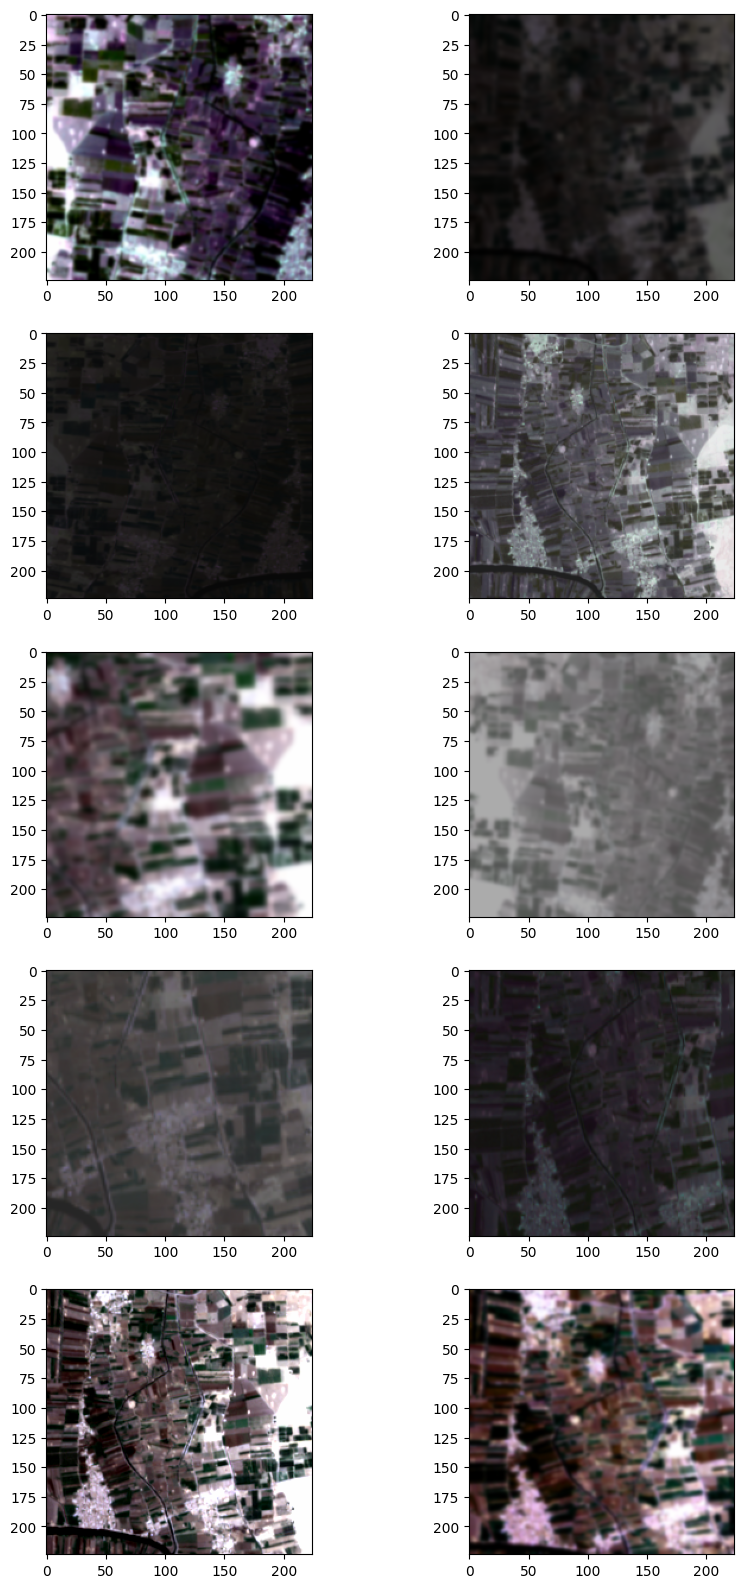

In [44]:
plt.figure(figsize=(10,20))
def view_data(ssl, index):
    for i in range(1,6):
        images = ssl[index]
        view1, view2 = images
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1,2,0))
        plt.subplot(5,2,2*i)
        plt.imshow(view2.permute(1,2,0))

view_data(ssl_ds,200)

In [45]:
BATCH_SIZE = 128

# Building the data loader
train_dl = torch.utils.data.DataLoader(
    ssl_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

# SimCLR Model

The data pipeline gives us two augmented views of an image. The views go into a neural network encoder $f(.)$ that gives us the corresponding representation of the augmented views. Our objective is to maximise the similarity quotient of the two distinct learned representations. The idea here is to force the model to learn a general representation of an object from two distinct augmented views of it. The intuition is quite similar to viewing an object from different perspectives and gaining a better understanding.

I have used ResNet18 as the data is quite small to use a bigger architecture. The similarity quotient comes from the representations learned by the encoder model. It was seen that projecting the encoded vector into a different latent space by an MLP helped in learning better (richer) representations. Here comes the projector $g(.)$ layer. The only objective of the projector is to project the encoder output to a richer latent space.

$$
h = f(x)\\
z = g(h)
$$

In [31]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class SimCLR(nn.Module):
    def __init__(self, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        resnet18 = models.resnet18(pretrained=False)
        resnet18.fc = Identity()
        self.encoder = resnet18
        self.projection = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256)
        )
    def forward(self, x):
        if not self.linear_eval:
            x = torch.cat(x, dim=0)

        encoding = self.encoder(x)
        projection = self.projection(encoding)
        return projection

In [32]:
LABELS = torch.cat([torch.arange(BATCH_SIZE) for i in range(2)], dim=0)
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
LABELS = LABELS.to(DEVICE) #128,128

In [33]:
LABELS

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0')

In [55]:
(LABELS[~mask].view(LABELS.shape[0], -1)).shape

torch.Size([256, 255])

# Contrastive Loss

The loss function is basically built on top of two things:
- softmax
- cosine similarity

With the projected vectors we perform a cosine similarity function to check how similar they are. We perform the cosine similarity upon both the positive and negative pairs. After we have the similarity matrix we perform a softmax to have a probability distribution of the entire model. Our objective is to tune the knobs of the model so that this softmax distribution is peaked on the positive pair. The paper uses negative log of the softmax,  here we will approach a similar idea and use the cross entropy loss with the softmax similarity distribution.

In [71]:
LABELS = torch.cat([torch.arange(BATCH_SIZE) for i in range(2)], dim=0)
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
LABELS = LABELS.to(DEVICE) #128,128

def cont_loss(features, temp):
    """
    The NTxent Loss.

    Args:
        z1: The projection of the first branch
        z2: The projeciton of the second branch

    Returns:
        the NTxent loss
    """
    similarity_matrix = torch.matmul(features, features.T) # 128, 128
    # discard the main diagonal from both: labels and similarities matrix
    mask = torch.eye(LABELS.shape[0], dtype=torch.bool).to(DEVICE)
    # ~mask is the negative of the mask
    # the view is required to bring the matrix back to shape
    labels = LABELS[~mask].view(LABELS.shape[0], -1) # 128, 127
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1) # 128, 127

    # select and combine multiple positives
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1) # 128, 1

    # select only the negatives
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1) # 128, 126

    logits = torch.cat([positives, negatives], dim=1) # 128, 127
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)
    labels[0] = 1

    logits = logits / temp
    #print(logits.shape, positives.shape, negatives.shape, labels.shape)
    return logits, labels

In [74]:
simclr_model = SimCLR().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(simclr_model.parameters())

import warnings
warnings.filterwarnings("ignore")

In [75]:
EPOCHS = 100
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    for i, views in enumerate(train_dl):
        projections = simclr_model([view.to(DEVICE) for view in views])
        logits, labels = cont_loss(projections, temp=2)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        #if i % 10 == 9:    # print every 10 mini-batches
        print(f'EPOCH: {epoch+1} BATCH: {i+1} LOSS: {(running_loss/100):.4f} ')
        running_loss = 0.0
    print(f'Time taken: {((time.time()-t0)/60):.3f} mins')

EPOCH: 1 BATCH: 1 LOSS: 0.1491 
EPOCH: 1 BATCH: 2 LOSS: 0.0862 
EPOCH: 1 BATCH: 3 LOSS: 0.0597 
Time taken: 0.195 mins
EPOCH: 2 BATCH: 1 LOSS: 0.0569 
EPOCH: 2 BATCH: 2 LOSS: 0.0557 
EPOCH: 2 BATCH: 3 LOSS: 0.0561 
Time taken: 0.198 mins
EPOCH: 3 BATCH: 1 LOSS: 0.0554 
EPOCH: 3 BATCH: 2 LOSS: 0.0555 
EPOCH: 3 BATCH: 3 LOSS: 0.0554 
Time taken: 0.201 mins
EPOCH: 4 BATCH: 1 LOSS: 0.0550 
EPOCH: 4 BATCH: 2 LOSS: 0.0553 
EPOCH: 4 BATCH: 3 LOSS: 0.0543 
Time taken: 0.195 mins
EPOCH: 5 BATCH: 1 LOSS: 0.0545 
EPOCH: 5 BATCH: 2 LOSS: 0.0533 
EPOCH: 5 BATCH: 3 LOSS: 0.0548 
Time taken: 0.193 mins
EPOCH: 6 BATCH: 1 LOSS: 0.0543 
EPOCH: 6 BATCH: 2 LOSS: 0.0544 
EPOCH: 6 BATCH: 3 LOSS: 0.0543 
Time taken: 0.183 mins
EPOCH: 7 BATCH: 1 LOSS: 0.0546 
EPOCH: 7 BATCH: 2 LOSS: 0.0547 
EPOCH: 7 BATCH: 3 LOSS: 0.0542 
Time taken: 0.186 mins
EPOCH: 8 BATCH: 1 LOSS: 0.0546 
EPOCH: 8 BATCH: 2 LOSS: 0.0537 
EPOCH: 8 BATCH: 3 LOSS: 0.0541 
Time taken: 0.201 mins
EPOCH: 9 BATCH: 1 LOSS: 0.0539 
EPOCH: 9 BATCH: 

# Down Stream Task

For the downstream network, we choose a `classification` task. After we have a trained SimCLR model we will discard the projection head and use the encoder only. We provide a `Centre Cropped` image to the encoder and get a learned representation of the images. This representation is then used in down stream tasks like classification.

1. Here we train the representations to predict the classification task provided with the Eurosat - RGB dataset.

2. Eurosar is a sufficiently large dataset. Since the assignment asks for using a relatively smaller dataset, I choose randomly 100 images per class for the training.

In [76]:
from torchvision.transforms import (
    CenterCrop,
    Resize
)

In [106]:
resize = Resize(255)
ccrop = CenterCrop(224)
ttensor = ToTensor()

custom_transform = Compose([
    resize,
    ccrop,
    ttensor,
])

euro_ds = ImageFolder(
    root="/content/drive/MyDrive/cropin/eurosat/",
    transform=custom_transform
)

nu_classes = len(euro_ds.classes)
print("Number of classes : ",nu_classes)
BATCH_SIZE = 128

# Building the data loader
train_dl = torch.utils.data.DataLoader(
    euro_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

Number of classes :  10


In [107]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class LinearEvaluation(nn.Module):
    def __init__(self, model, nu_classes):
        super().__init__()
        simclr = model
        simclr.linear_eval = True
        simclr.projection = Identity()
        self.simclr = simclr
        for param in self.simclr.parameters():
            param.requires_grad = False
        self.linear = nn.Linear(512, nu_classes)
    def forward(self, x):
        encoding = self.simclr(x)
        pred = self.linear(encoding)
        return pred

In [108]:
eval_model = LinearEvaluation(simclr_model, nu_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(eval_model.parameters())

In [109]:
EPOCHS = 50
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    for i, element in enumerate(train_dl):
        image, label = element
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        pred = eval_model(image)
        #print(torch.argmax(pred,axis = 1))
        loss = criterion(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_acc = torch.sum(torch.argmax(pred,axis = 1) == label)

        # print statistics
        running_loss += loss.item()
        #if i % 10 == 9:    # print every 10 mini-batches
        print(f'EPOCH: {epoch+1} BATCH: {i+1} LOSS: {(running_loss/100):.4f} Accuracy: {train_acc/128 * 100:.4f}')
        running_loss = 0.0
    print(f'Time taken: {((time.time()-t0)/60):.3f} mins')

EPOCH: 1 BATCH: 1 LOSS: 0.0248 Accuracy: 0.0000
EPOCH: 1 BATCH: 2 LOSS: 0.0240 Accuracy: 11.0000
EPOCH: 1 BATCH: 3 LOSS: 0.0231 Accuracy: 8.0000
EPOCH: 1 BATCH: 4 LOSS: 0.0220 Accuracy: 14.0000
EPOCH: 1 BATCH: 5 LOSS: 0.0205 Accuracy: 39.0000
EPOCH: 1 BATCH: 6 LOSS: 0.0199 Accuracy: 48.0000
EPOCH: 1 BATCH: 7 LOSS: 0.0191 Accuracy: 42.0000
Time taken: 0.045 mins
EPOCH: 2 BATCH: 1 LOSS: 0.0184 Accuracy: 39.0000
EPOCH: 2 BATCH: 2 LOSS: 0.0177 Accuracy: 51.0000
EPOCH: 2 BATCH: 3 LOSS: 0.0179 Accuracy: 44.0000
EPOCH: 2 BATCH: 4 LOSS: 0.0172 Accuracy: 56.0000
EPOCH: 2 BATCH: 5 LOSS: 0.0165 Accuracy: 58.0000
EPOCH: 2 BATCH: 6 LOSS: 0.0159 Accuracy: 63.0000
EPOCH: 2 BATCH: 7 LOSS: 0.0162 Accuracy: 62.0000
Time taken: 0.046 mins
EPOCH: 3 BATCH: 1 LOSS: 0.0151 Accuracy: 65.0000
EPOCH: 3 BATCH: 2 LOSS: 0.0152 Accuracy: 68.0000
EPOCH: 3 BATCH: 3 LOSS: 0.0156 Accuracy: 65.0000
EPOCH: 3 BATCH: 4 LOSS: 0.0146 Accuracy: 73.0000
EPOCH: 3 BATCH: 5 LOSS: 0.0136 Accuracy: 75.0000
EPOCH: 3 BATCH: 6 LOSS: 0

# Test code: with SSL learnt pretext task
Created a test dataset from the Eurosar -RGB data, where we randomly choose 20 images per class (non-overlapping with the test images).

In [110]:
resize = Resize(255)
ccrop = CenterCrop(224)
ttensor = ToTensor()

custom_transform = Compose([
    resize,
    ccrop,
    ttensor,
])

euro_ds_test = ImageFolder(
    root="/content/drive/MyDrive/cropin/eurosat_test/",
    transform=custom_transform
)

# Building the data loader
test_dl = torch.utils.data.DataLoader(
    euro_ds_test,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

In [156]:
t0 = time.time()
running_loss = 0.0
for i, element in enumerate(test_dl):
    image, label = element
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    pred = eval_model(image)
    loss = criterion(pred, label)
    train_acc = torch.sum(torch.argmax(pred,axis = 1) == label)

    # print statistics
    running_loss += loss.item()
    #if i % 10 == 9:    # print every 10 mini-batches
    print(f'LOSS: {(running_loss/100):.4f} Accuracy: {train_acc/128 * 100:.4f}')
    running_loss = 0.0
print(f'Time taken: {((time.time()-t0)/60):.3f} mins')

LOSS: 0.0065 Accuracy: 85.9375
Time taken: 0.017 mins


# Comparison: Performance without a pretext task

Used a similar network architecture with a ResNet18 encoder (for fair comparison as the pretext task did have a ResNet18 backbone). Remaining network architecture remains same as the projection head of the SSL network. The training setup is also kept same as the previous one for consistency.

## Training

In [132]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class CompEvaluation(nn.Module):
    def __init__(self, nu_classes):
        super().__init__()
        resnet18 = models.resnet18(pretrained=False)
        resnet18.fc= Identity()
        self.encoder = resnet18
        self.projection = nn.Linear(512, nu_classes)

    def forward(self, x):
        encoding = self.encoder(x)
        projection = self.projection(encoding)
        return projection


'\n    def forward(self, x):\n        encoding = self.simclr(x)\n        pred = self.linear(encoding)\n        return pred\n'

In [136]:
eval_model =  CompEvaluation(nu_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(eval_model.parameters())

In [137]:
EPOCHS = 50
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    for i, element in enumerate(train_dl):
        image, label = element
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        pred = eval_model(image)
        loss = criterion(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_acc = torch.sum(torch.argmax(pred,axis = 1) == label)

        # print statistics
        running_loss += loss.item()
        print(f'EPOCH: {epoch+1} BATCH: {i+1} LOSS: {(running_loss/100):.4f} Accuracy: {train_acc/BATCH_SIZE * 100:.4f}')
        running_loss = 0.0
    print(f'Time taken: {((time.time()-t0)/60):.3f} mins')

EPOCH: 1 BATCH: 1 LOSS: 0.0242 Accuracy: 13.2812
EPOCH: 1 BATCH: 2 LOSS: 0.0235 Accuracy: 21.8750
EPOCH: 1 BATCH: 3 LOSS: 0.0198 Accuracy: 36.7188
EPOCH: 1 BATCH: 4 LOSS: 0.0159 Accuracy: 48.4375
EPOCH: 1 BATCH: 5 LOSS: 0.0154 Accuracy: 45.3125
EPOCH: 1 BATCH: 6 LOSS: 0.0156 Accuracy: 41.4062
EPOCH: 1 BATCH: 7 LOSS: 0.0168 Accuracy: 44.5312
Time taken: 0.073 mins
EPOCH: 2 BATCH: 1 LOSS: 0.0123 Accuracy: 62.5000
EPOCH: 2 BATCH: 2 LOSS: 0.0130 Accuracy: 52.3438
EPOCH: 2 BATCH: 3 LOSS: 0.0137 Accuracy: 52.3438
EPOCH: 2 BATCH: 4 LOSS: 0.0123 Accuracy: 52.3438
EPOCH: 2 BATCH: 5 LOSS: 0.0111 Accuracy: 60.9375
EPOCH: 2 BATCH: 6 LOSS: 0.0125 Accuracy: 50.7812
EPOCH: 2 BATCH: 7 LOSS: 0.0104 Accuracy: 63.2812
Time taken: 0.074 mins
EPOCH: 3 BATCH: 1 LOSS: 0.0118 Accuracy: 60.9375
EPOCH: 3 BATCH: 2 LOSS: 0.0112 Accuracy: 58.5938
EPOCH: 3 BATCH: 3 LOSS: 0.0095 Accuracy: 68.7500
EPOCH: 3 BATCH: 4 LOSS: 0.0118 Accuracy: 62.5000
EPOCH: 3 BATCH: 5 LOSS: 0.0109 Accuracy: 61.7188
EPOCH: 3 BATCH: 6 LOSS:

## Testing
With same experimental setting

In [154]:
t0 = time.time()
running_loss = 0.0
for i, element in enumerate(test_dl):
    image, label = element
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    pred = eval_model(image)
    loss = criterion(pred, label)
    train_acc = torch.sum(torch.argmax(pred,axis = 1) == label)

    # print statistics
    running_loss += loss.item()
    #if i % 10 == 9:    # print every 10 mini-batches
    print(f'LOSS: {(running_loss/100):.4f} Accuracy: {train_acc/128 * 100:.4f}')
    running_loss = 0.0
print(f'Time taken: {((time.time()-t0)/60):.3f} mins')

LOSS: 0.0083 Accuracy: 78.1250
Time taken: 0.015 mins


#Results and Conclusion:

The SSL based network gave a classification accuracy of 85.93% on the subset of Eurosat - RGB dataset. On the same subset of the data, a network learnt from scratch using purely a supervised learning approach resulted into a test accuracy of 78.125%.  This clearly shows the efficacy of using a SSL approach for training when we have limited labelled data.

# Things I would have done differently if I had more time and more compute units:

1. Instead of simply using the RGB data, using multi-modal data could benefit the learning more.
2. Exploit the geographic coordinates of the points to mine the hard postives and hard negative samples for the contrastive learning module.
3. Do more analysis and see if SSL really helps in this case. The SSL4EO - RGB dataset looks very different from the Eurosat RGB images. Are they really helpful or a simple ANN or a graph CNN based module might have been more helpful.
4. Loss and accuracy for both the models are not stabilized yet. More hidden layers, attention networks, batch normalization, etc would help in fine-tuning the results further. I could not play around much as I had lost my Google Colab compute units.
5. Use a validation set and insert a convergence evaluator during the training process, instead of training for a fixed number of epochs.

### References

I have taken help from the following places:
- [SimCLR](https://arxiv.org/abs/2002.05709)
- [Official SimCLR repository](https://github.com/google-research/simclr)
- [Amit Chaudhary's blog on SimCLR](https://amitness.com/2020/03/illustrated-simclr/)
- [Sayak Paul's blog on SimCLR](https://wandb.ai/sayakpaul/simclr/reports/Towards-Self-Supervised-Image-Understanding-with-SimCLR--VmlldzoxMDI5NDM)
- [@sthalles' SimCLR implementation in PyTorch](https://github.com/sthalles/SimCLR)
- [Aritra Roy's Kaggle blog](https://www.kaggle.com/code/aritrag/simclr/comments#2620126)